#Import Library

In [1]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

## GDrive Acces

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


# Make variabel to define path of directory TRAIN, and VALIDATION



In [3]:
clean_dir ='/content/drive/MyDrive/ML Team/dataset_clean'
TRAIN_dir = os.path.join(clean_dir, 'train')
VAL_dir = os.path.join(clean_dir, 'val')

# Image Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, # mengonversi piksel dalam rentang [0,255] menjadi rentang [0,1].
    horizontal_flip = True, #untuk membalik posisi suatu citra secara horizontal
    vertical_flip = True,
    rotation_range=45,
    brightness_range=[0.5,1.0],
    fill_mode='nearest'
)

val_datagen =ImageDataGenerator( rescale=1./255 )

In [5]:
BATCH_SIZE = 64
train_generator = train_datagen.flow_from_directory(
    TRAIN_dir, #hyperparameter berupa path directory yang berisi path directory
    target_size = (224,224), # besaran nilai pixel yang akan diambil dari citra yang akan dibaca.
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode='rgb'

)

validation_generator = val_datagen.flow_from_directory(
    VAL_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode='rgb'

)


nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 3627 images belonging to 10 classes.
Found 817 images belonging to 10 classes.
Classes: ['ban', 'botol_plastik', 'bungkus_plastik', 'cup_gelas', 'galon', 'kaca', 'kaleng', 'kardus', 'kertas', 'sampah_organik']


In [6]:
train_generator.class_indices

{'ban': 0,
 'botol_plastik': 1,
 'bungkus_plastik': 2,
 'cup_gelas': 3,
 'galon': 4,
 'kaca': 5,
 'kaleng': 6,
 'kardus': 7,
 'kertas': 8,
 'sampah_organik': 9}

## Displays a sample image of the generator train

In [7]:
def show_image_samples(gen):
    train_dict=train_generator.class_indices
    classes=list(train_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(30, 30))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [8]:
show_image_samples(train_generator)

Output hidden; open in https://colab.research.google.com to view.

# Build the model

## MobileNetV2




In [9]:
base_model = DenseNet121(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [10]:
for layer in base_model.layers[:200]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Pastikan untuk membuat model dengan base_model.input sebagai input
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [12]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
loss='categorical_crossentropy',
metrics = ['accuracy'])

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

## Fit and Train the Model

In [14]:
history = model.fit(train_generator,
               epochs=100,
               validation_data=validation_generator,
               callbacks=[callback])

Epoch 1/100
57/57 [==============================] - 1268s 21s/step - loss: 2.0007 - accuracy: 0.3259 - val_loss: 0.9362 - val_accuracy: 0.7797
Epoch 2/100
57/57 [==============================] - 100s 2s/step - loss: 1.0330 - accuracy: 0.6498 - val_loss: 0.3668 - val_accuracy: 0.9033
Epoch 3/100
57/57 [==============================] - 100s 2s/step - loss: 0.6258 - accuracy: 0.8089 - val_loss: 0.2214 - val_accuracy: 0.9302
Epoch 4/100
57/57 [==============================] - 99s 2s/step - loss: 0.4362 - accuracy: 0.8677 - val_loss: 0.1655 - val_accuracy: 0.9498
Epoch 5/100
57/57 [==============================] - 101s 2s/step - loss: 0.3422 - accuracy: 0.9049 - val_loss: 0.1620 - val_accuracy: 0.9498
Epoch 6/100
57/57 [==============================] - 100s 2s/step - loss: 0.2533 - accuracy: 0.9283 - val_loss: 0.1254 - val_accuracy: 0.9645
Epoch 7/100
57/57 [==============================] - 101s 2s/step - loss: 0.2082 - accuracy: 0.9388 - val_loss: 0.1793 - val_accuracy: 0.9498
Epoch

#EVALUATION (ACCURACY LEVEL & MODEL LOSS)

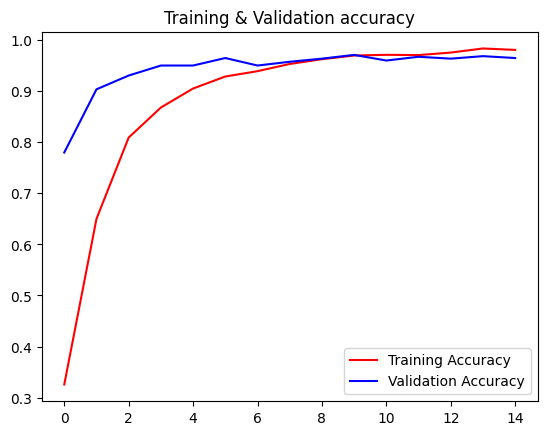

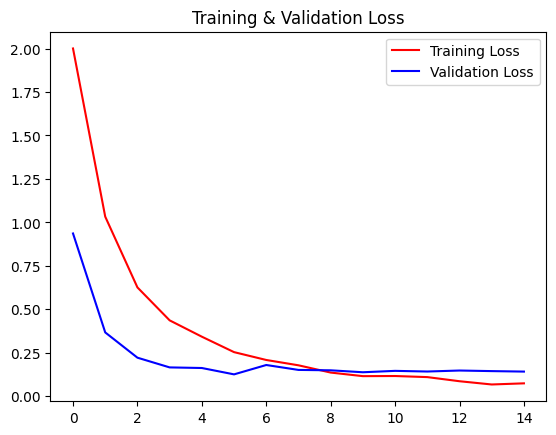

In [15]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(len(acc))

plt.plot(epoch, acc, 'r', label = 'Training Accuracy')
plt.plot(epoch, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training & Validation accuracy')
plt.legend(loc = 'best')
plt.show()


plt.plot(epoch, loss, 'r', label = 'Training Loss')
plt.plot(epoch, val_loss, 'b', label = 'Validation Loss')
plt.title('Training & Validation Loss')
plt.legend(loc = 'best')
plt.show()

In [16]:
# Using the validation dataset
score = model.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

<ipython-input-16-0b1386c018fa>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator)


Val loss: 0.14138446748256683
Val accuracy: 0.9645043015480042


# Test the Model with image outside train and val directory

## Upload Image

In [17]:
waste_class = classes
print('\nClass of waste dataset:\n{}'.format(waste_class))


Class of waste dataset:
['ban', 'botol_plastik', 'bungkus_plastik', 'cup_gelas', 'galon', 'kaca', 'kaleng', 'kardus', 'kertas', 'sampah_organik']


In [18]:
from PIL import Image
from numpy import asarray

def preprocess_image_as_array(path, show_output):
    im = Image.open(path).convert('RGB')
    im = im.resize((224, 224))

    plt.figure(figsize=(8, 8))
    plt.imshow(im)
    plt.axis('off')

    image_as_array = np.expand_dims(asarray(im), axis=0)
    scaled_image_as_array = np.true_divide(image_as_array, 255)

    if show_output:
        print('Gambar {} selesai di proses.'.format(path))
    return scaled_image_as_array

def preprocess_and_predict(image_path, show_output=True):
    image_as_array = preprocess_image_as_array(image_path, show_output)
    pred = model.predict(image_as_array)
    sorted_ranks = np.flip(np.argsort(pred[0]))

    if show_output:
        rank = 1
        print('Prediksi Sampah:')
        for waste_rank in sorted_ranks:
            print('{:2}. {:16}: {:.3f}'.format(rank, waste_class[waste_rank], pred[0][waste_rank]))
            rank += 1
    print('')

Gambar /content/depositphotos_118533006-stock-photo-coca-colafanta-and-sprite-cans.jpg selesai di proses.
1/1 [==============================] - 4s 4s/step
Prediksi Sampah:
 1. kaleng          : 1.000
 2. bungkus_plastik : 0.000
 3. cup_gelas       : 0.000
 4. botol_plastik   : 0.000
 5. galon           : 0.000
 6. kertas          : 0.000
 7. kardus          : 0.000
 8. ban             : 0.000
 9. kaca            : 0.000
10. sampah_organik  : 0.000



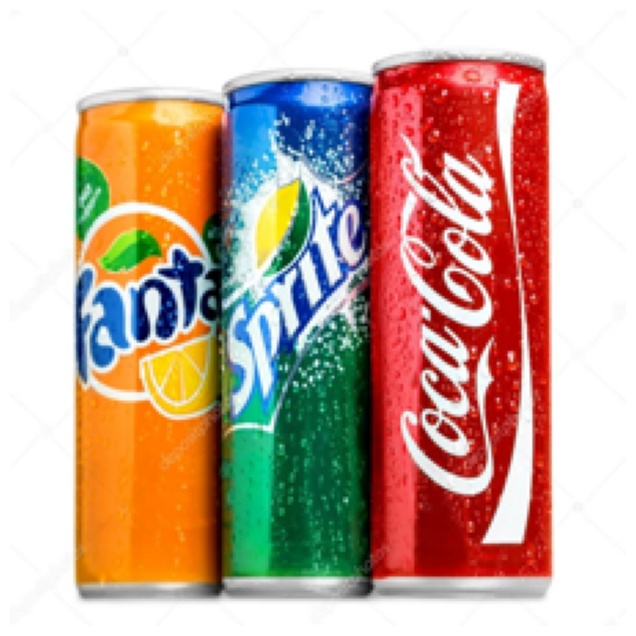

In [19]:
IMAGE_PATH = "/content/depositphotos_118533006-stock-photo-coca-colafanta-and-sprite-cans.jpg"
preprocess_and_predict(IMAGE_PATH)

Gambar /content/be00bca5-c05b-4517-85cd-9a33d9ca9230.jpg selesai di proses.
1/1 [==============================] - 0s 32ms/step
Prediksi Sampah:
 1. ban             : 1.000
 2. kaleng          : 0.000
 3. kaca            : 0.000
 4. cup_gelas       : 0.000
 5. bungkus_plastik : 0.000
 6. galon           : 0.000
 7. botol_plastik   : 0.000
 8. kardus          : 0.000
 9. kertas          : 0.000
10. sampah_organik  : 0.000



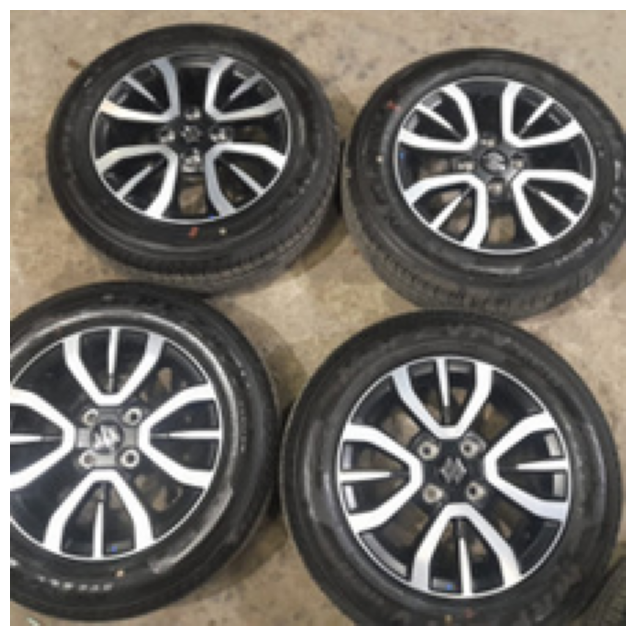

In [20]:
IMAGE_PATH = "/content/be00bca5-c05b-4517-85cd-9a33d9ca9230.jpg"
preprocess_and_predict(IMAGE_PATH)

Gambar /content/185e1ecb613f2c99b67d4e8f74f0e7f6.jpg selesai di proses.
1/1 [==============================] - 0s 30ms/step
Prediksi Sampah:
 1. cup_gelas       : 1.000
 2. bungkus_plastik : 0.000
 3. kaleng          : 0.000
 4. botol_plastik   : 0.000
 5. ban             : 0.000
 6. galon           : 0.000
 7. kaca            : 0.000
 8. kertas          : 0.000
 9. kardus          : 0.000
10. sampah_organik  : 0.000



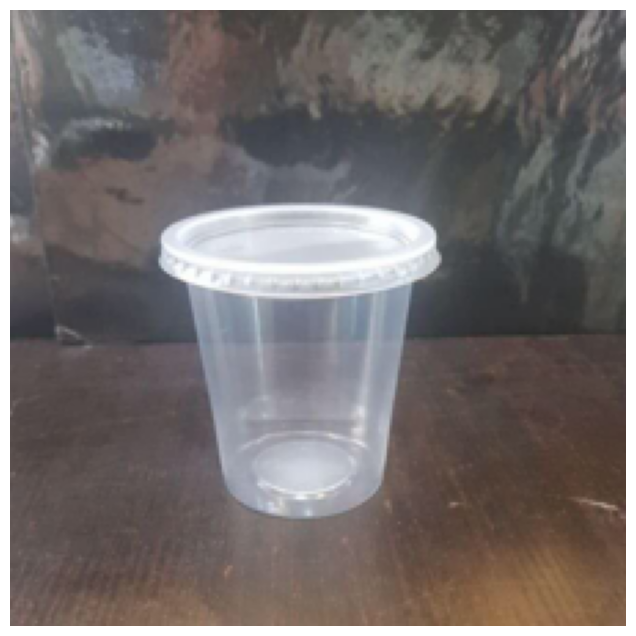

In [21]:
IMAGE_PATH = "/content/185e1ecb613f2c99b67d4e8f74f0e7f6.jpg"
preprocess_and_predict(IMAGE_PATH)

Gambar /content/no-brand_gelas-cup-pop-ice-cup-jus-buah-cup-gelas-jualan-es-uk-12-14-16_full01.jpg selesai di proses.
1/1 [==============================] - 0s 29ms/step
Prediksi Sampah:
 1. cup_gelas       : 1.000
 2. kaleng          : 0.000
 3. bungkus_plastik : 0.000
 4. botol_plastik   : 0.000
 5. galon           : 0.000
 6. ban             : 0.000
 7. kaca            : 0.000
 8. kertas          : 0.000
 9. kardus          : 0.000
10. sampah_organik  : 0.000



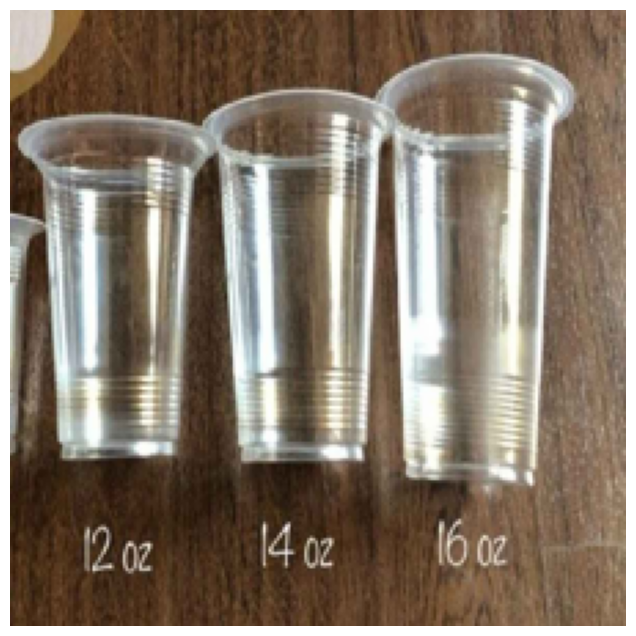

In [22]:
IMAGE_PATH = "/content/no-brand_gelas-cup-pop-ice-cup-jus-buah-cup-gelas-jualan-es-uk-12-14-16_full01.jpg"
preprocess_and_predict(IMAGE_PATH)

Gambar /content/4805fa9a6d9e10e270f8901e22ac5ce4.jpg selesai di proses.
1/1 [==============================] - 0s 53ms/step
Prediksi Sampah:
 1. botol_plastik   : 0.620
 2. kaca            : 0.378
 3. kertas          : 0.001
 4. sampah_organik  : 0.000
 5. kaleng          : 0.000
 6. bungkus_plastik : 0.000
 7. ban             : 0.000
 8. cup_gelas       : 0.000
 9. galon           : 0.000
10. kardus          : 0.000



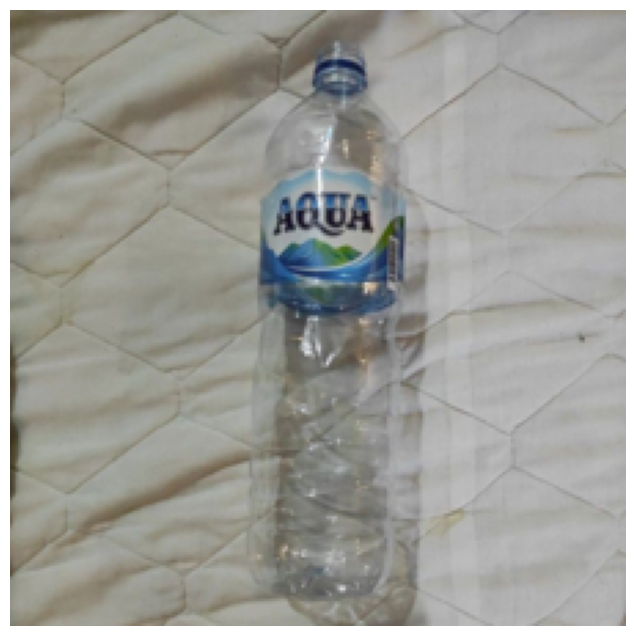

In [23]:
IMAGE_PATH = "/content/4805fa9a6d9e10e270f8901e22ac5ce4.jpg"
preprocess_and_predict(IMAGE_PATH)

Gambar /content/kulit-pisang.jpg selesai di proses.
1/1 [==============================] - 0s 57ms/step
Prediksi Sampah:
 1. sampah_organik  : 1.000
 2. botol_plastik   : 0.000
 3. kaca            : 0.000
 4. bungkus_plastik : 0.000
 5. kertas          : 0.000
 6. kaleng          : 0.000
 7. kardus          : 0.000
 8. galon           : 0.000
 9. ban             : 0.000
10. cup_gelas       : 0.000



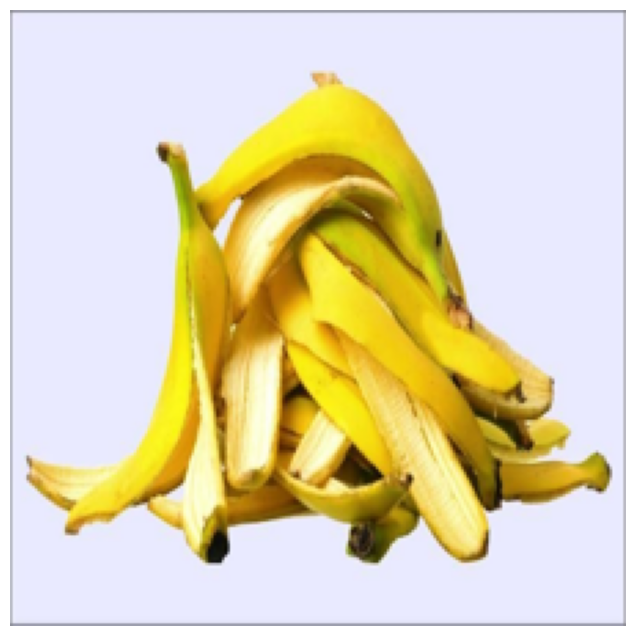

In [24]:
IMAGE_PATH = "/content/kulit-pisang.jpg"
preprocess_and_predict(IMAGE_PATH)

# Deploy the model to h5 file

In [25]:
from keras.models import load_model
model.save('/content/drive/MyDrive/ML Team/modelDenseNet121_finetune.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Convert the model to TFlite

In [26]:
tflite_model = tf.keras.models.load_model("/content/drive/MyDrive/ML Team/modelDenseNet121_finetune.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_save = converter.convert()
open("/content/drive/MyDrive/ML Team/modelDenseNet121_finetune.tflite", "wb").write(tflite_save)

7966840